In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import math
import torch

In [26]:
def show_samples(n_samples, samples_dir, title:str) :
    n_samples_to_show = n_samples   
    sample_files = os.listdir(samples_dir)

    # Vérifie qu'il y a assez d'images
    n_samples_to_show = min(n_samples_to_show, len(sample_files))

    # Sélectionne aléatoirement les fichiers
    chosen_files = np.random.choice(sample_files, size=n_samples_to_show, replace=False)

    # ----- calcul dynamique de la grille -----
    cols = min(5, n_samples_to_show)  # max 5 par ligne
    rows = math.ceil(n_samples_to_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))

    # Si n_samples < nb total de cases, il faut "flatten" proprement
    axes = np.atleast_1d(axes).flatten()

    for ax, file in zip(axes, chosen_files):
        img = Image.open(os.path.join(samples_dir, file)).convert("L")
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    # Désactive les cases vides (si le dernier rang n’est pas complet)
    for ax in axes[len(chosen_files):]:
        ax.axis('off')

    fig.suptitle(
        title,
        fontsize=12, y=1.02
    )
    plt.tight_layout()
    plt.show()


def generate_and_show_samples(model, cluster_id=0, n_samples=25, batch_size=32, device="mps"):
    """
    Génère et affiche des échantillons d'un cluster donné du GMGAN.

    Args:
        model: modèle GeneratorGMGAN chargé
        cluster_id: index du cluster à partir duquel échantillonner (int)
        n_samples: nombre total d'images à générer
        batch_size: taille des batchs pendant la génération
        device: "cpu", "cuda" ou "mps"
    """
    model.eval()
    generated_images = []

    with torch.no_grad():
        n_generated = 0
        while n_generated < n_samples:
            # crée un batch rempli du cluster_id choisi
            z = model.sample_from_mixture(torch.full((batch_size,), cluster_id, dtype=torch.long).to(device))
            x = model(z).reshape(batch_size, 28, 28)

            # inverse normalisation si besoin (cas classique de Normalize((0.5,), (0.5,)))
            x = (x + 1) / 2
            x = torch.clamp(x, 0, 1)

            for k in range(x.shape[0]):
                if n_generated < n_samples:
                    generated_images.append(x[k].cpu())
                    n_generated += 1

    # --- Affichage dynamique en grille ---
    cols = min(5, n_samples)
    rows = math.ceil(n_samples / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(2.2 * cols, 2.2 * rows))
    axes = np.atleast_1d(axes).flatten()

    for i, ax in enumerate(axes):
        if i < len(generated_images):
            ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')

    fig.suptitle(f"From a specific cluster", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()


def generate_grid_all_clusters(
    model, 
    K, 
    n_samples=10, 
    batch_size=32, 
    device="mps",
    title="GMGAN clusters"
):
    model.eval()

    all_imgs = []

    with torch.no_grad():
        for cluster_id in range(K):
            imgs_cluster = []
            n_generated = 0

            while n_generated < n_samples:
                z = model.sample_from_mixture(
                    torch.full((batch_size,), cluster_id, dtype=torch.long, device=device)
                )
                x = model(z).reshape(batch_size, 28, 28)
                x = (x + 1) / 2
                x = torch.clamp(x, 0, 1)

                to_take = min(batch_size, n_samples - n_generated)
                imgs_cluster.append(x[:to_take].cpu())
                n_generated += to_take

            imgs_cluster = torch.cat(imgs_cluster, dim=0)  # n_samples x 28 x 28
            all_imgs.append(imgs_cluster)

    all_imgs = torch.stack(all_imgs)  # K x n_samples x 28 x 28

    # plotting
    fig, axes = plt.subplots(K, n_samples, figsize=(1.8*n_samples, 1.8*K))
    for i in range(K):
        for j in range(n_samples):
            axes[i, j].imshow(all_imgs[i, j], cmap='gray')
            axes[i, j].axis('off')

    fig.suptitle(title, y=0.99)
    plt.tight_layout()
    plt.show()


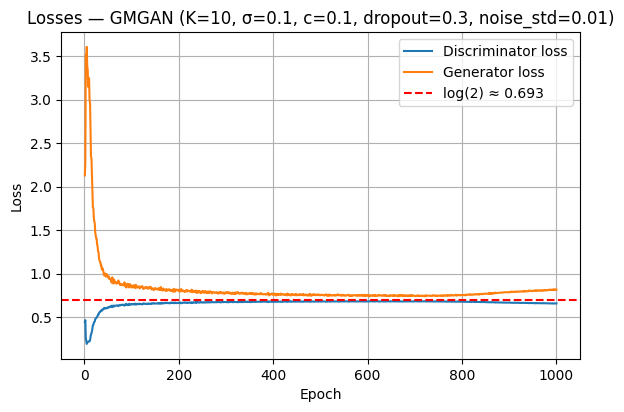

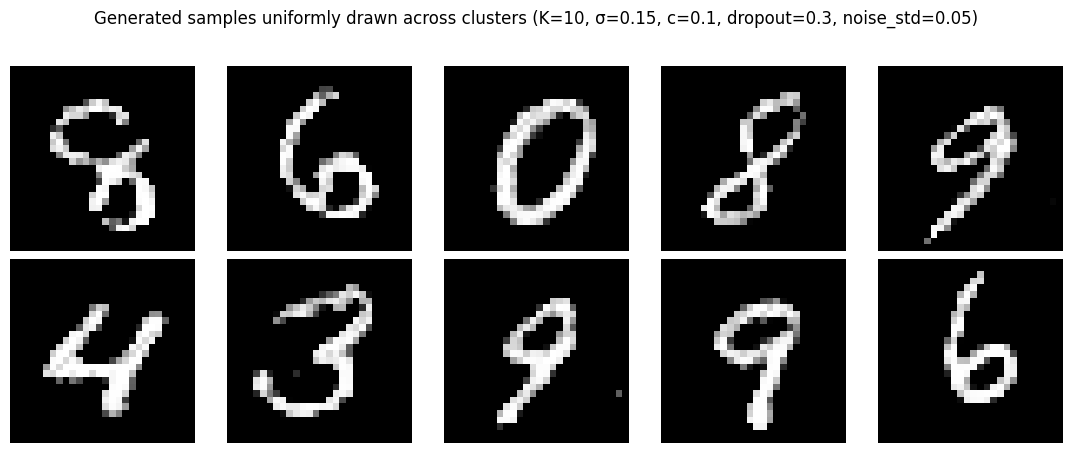

In [8]:
path_historic = '/Users/louiscarron/Documents/SCOLARITE/4A/cours/DSLab/Assignment_2/repo/assignment2-2025-dsl/gaussian_mixture/checkpoints/slurm/gmm_ld100_K10_sig0.1_c0.1_dd0.3_lr2e-04_bd64_bg128_2025-11-15_00-30_/'
samples_dir = os.path.join(path_historic, "samples")

df_hist_1 = pd.read_csv(path_historic + 'historic.csv')

plt.figure(figsize=(6,4))
plt.plot(df_hist_1["epoch"], df_hist_1["d_loss"], label="Discriminator loss")
plt.plot(df_hist_1["epoch"], df_hist_1["g_loss"], label="Generator loss")
plt.axhline(np.log(2), color='red', linestyle='--', linewidth=1.5, label='log(2) ≈ {:.3f}'.format(np.log(2)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.title("Losses — GMGAN (K=10, σ=0.1, c=0.1, dropout=0.3, noise_std=0.01)", fontsize=12)
plt.show()

show_samples(10, samples_dir, f"Generated samples uniformly drawn across clusters (K=10, σ=0.15, c=0.1, dropout=0.3, noise_std=0.05)")

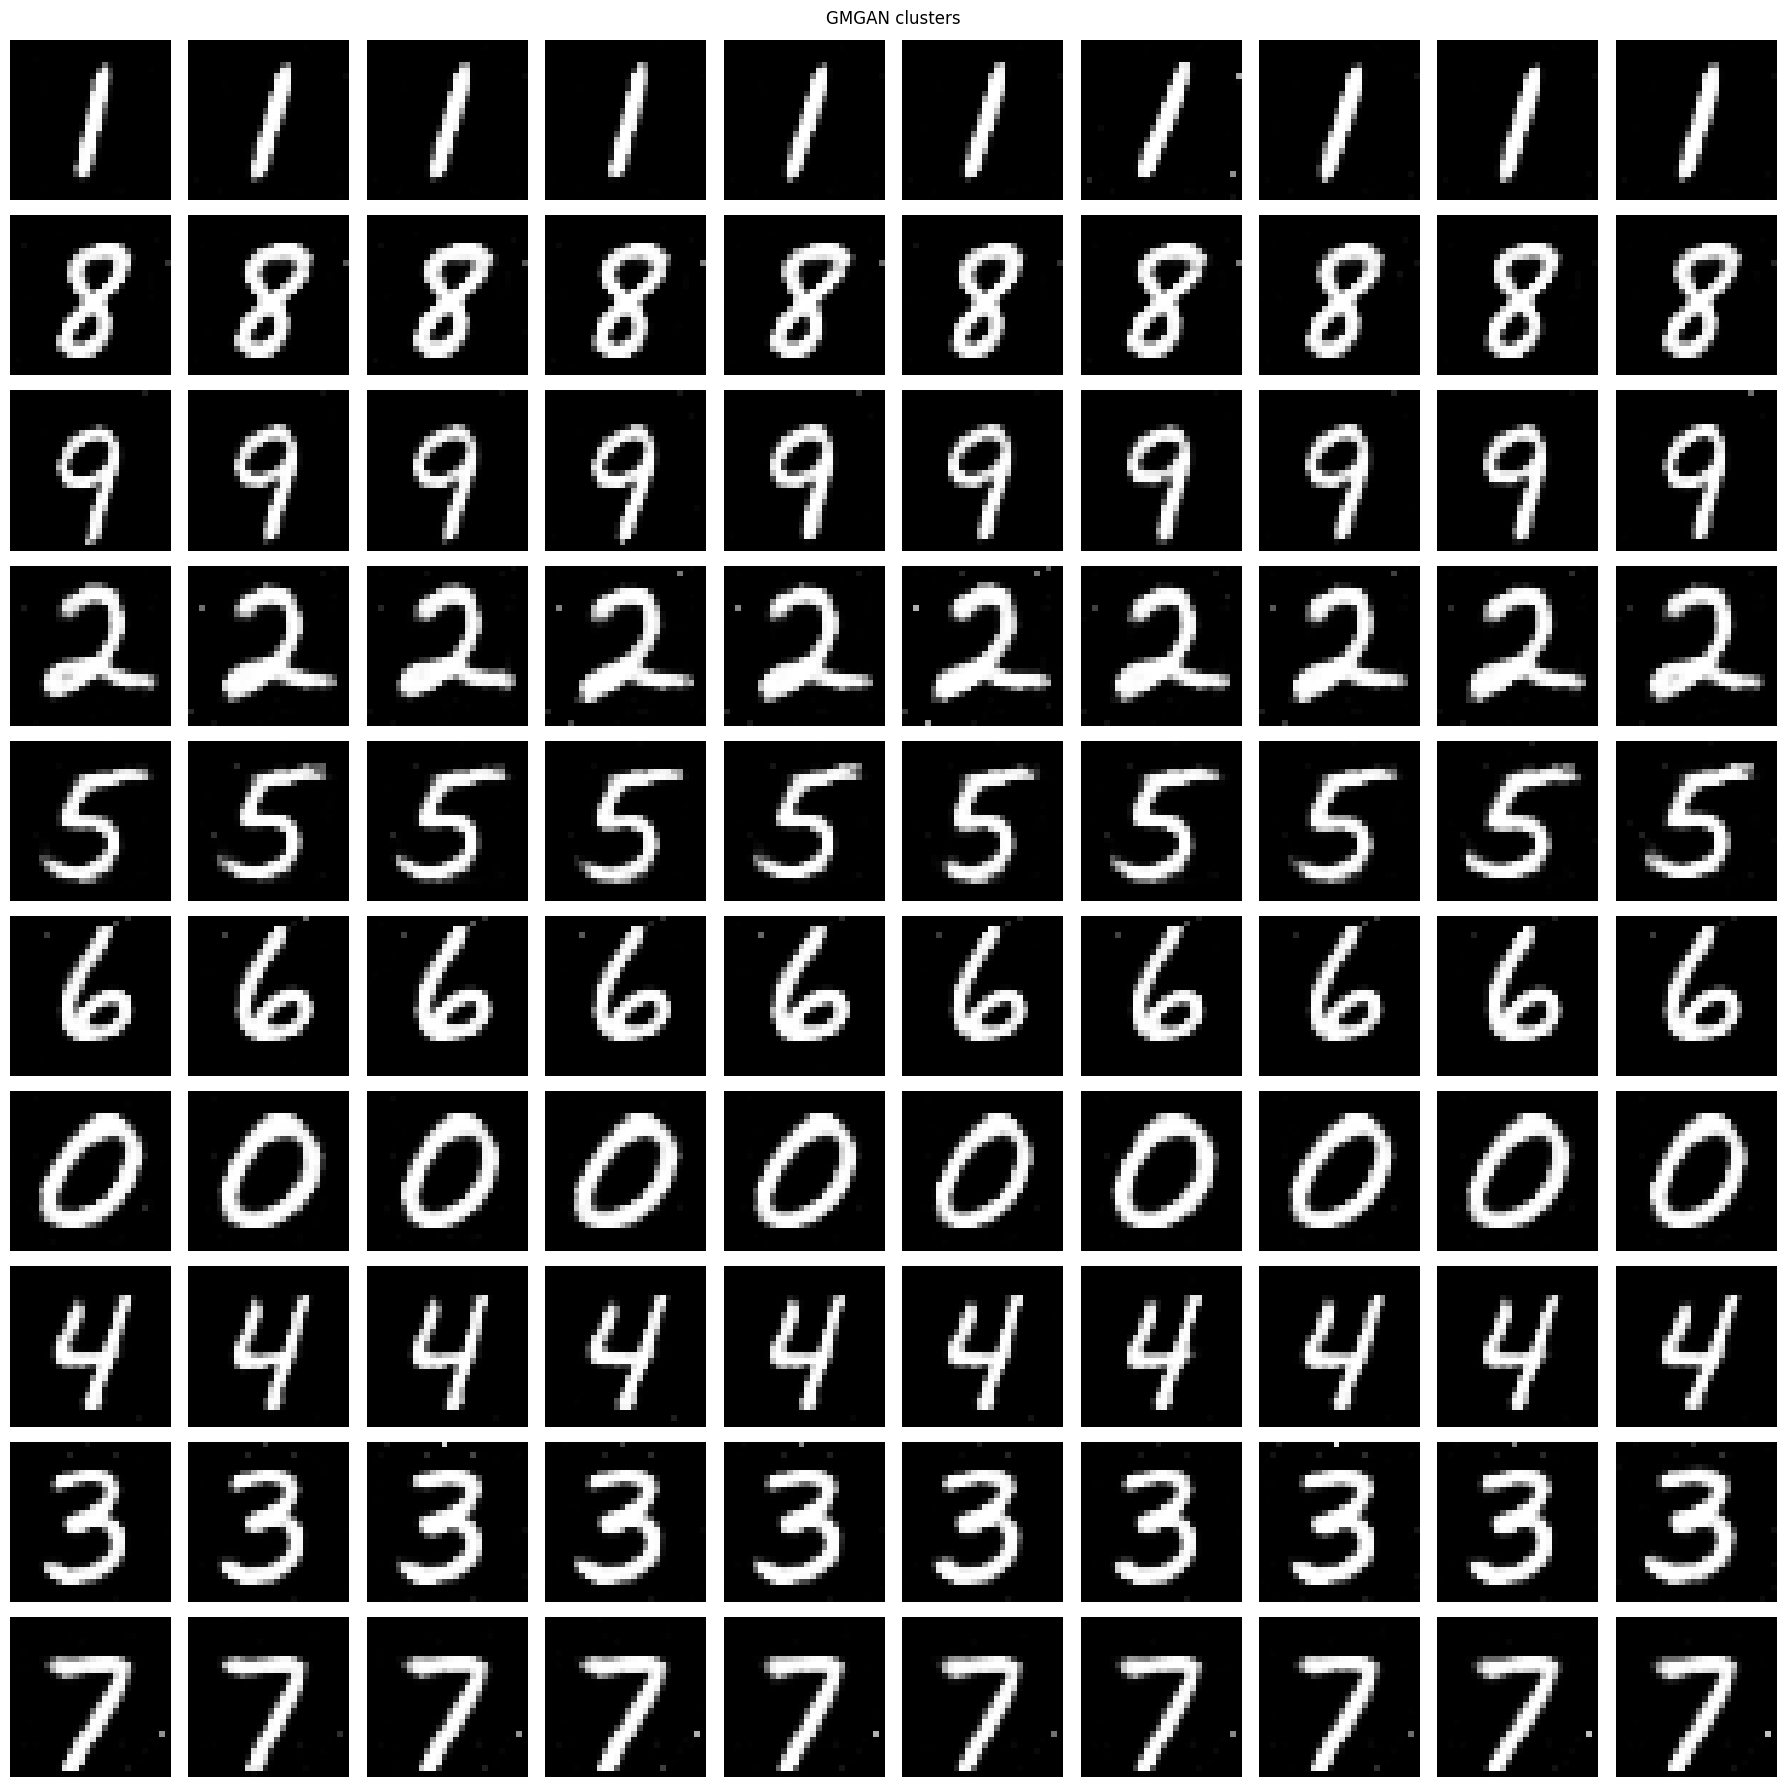

In [17]:
import sys
sys.path.append("../gaussian_mixture/")
from model import GeneratorGMGAN
import torch

checkpoint_path = path_historic + "G_GMGAN.pth"

mnist_dim = 784
latent_dim = 100
K = 10
c = 0.1
sigma = 0.01
batch_generator = 128
device="mps"

model = GeneratorGMGAN(
        g_output_dim=mnist_dim, 
        latent_space_dim=latent_dim, 
        batch_generator=batch_generator, 
        K=K, 
        c=c, 
        sigma=sigma
        ).to(device)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

generate_grid_all_clusters(model, K=10, n_samples=10, device=device)


=== Sigma = 0.01 ===


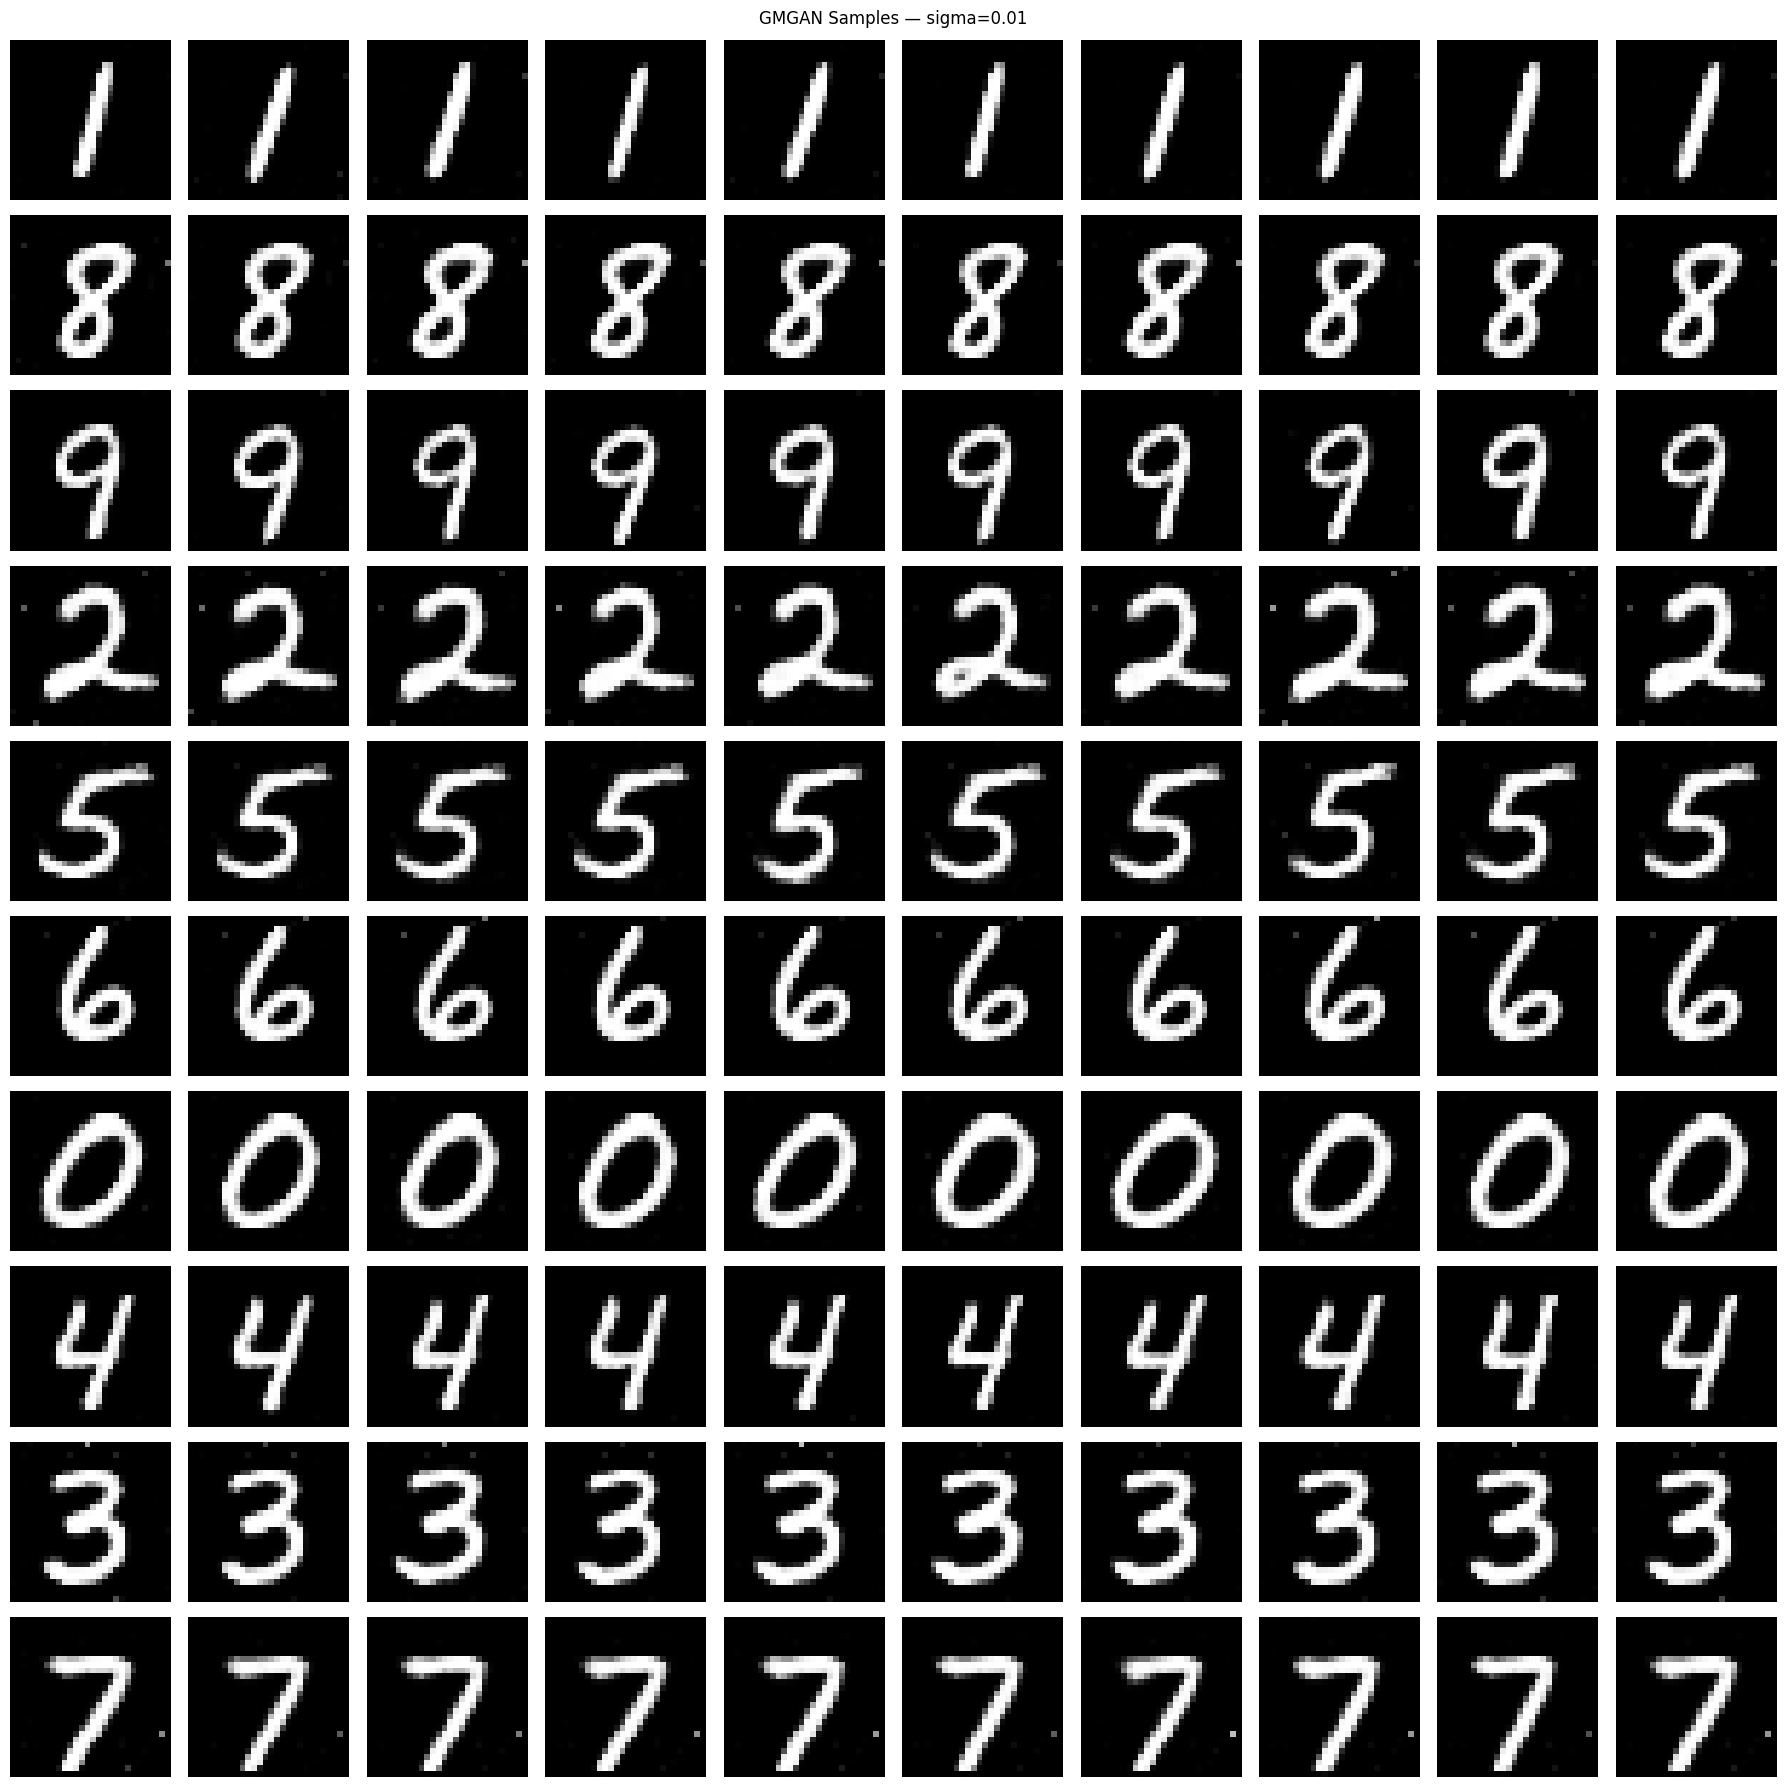


=== Sigma = 0.05 ===


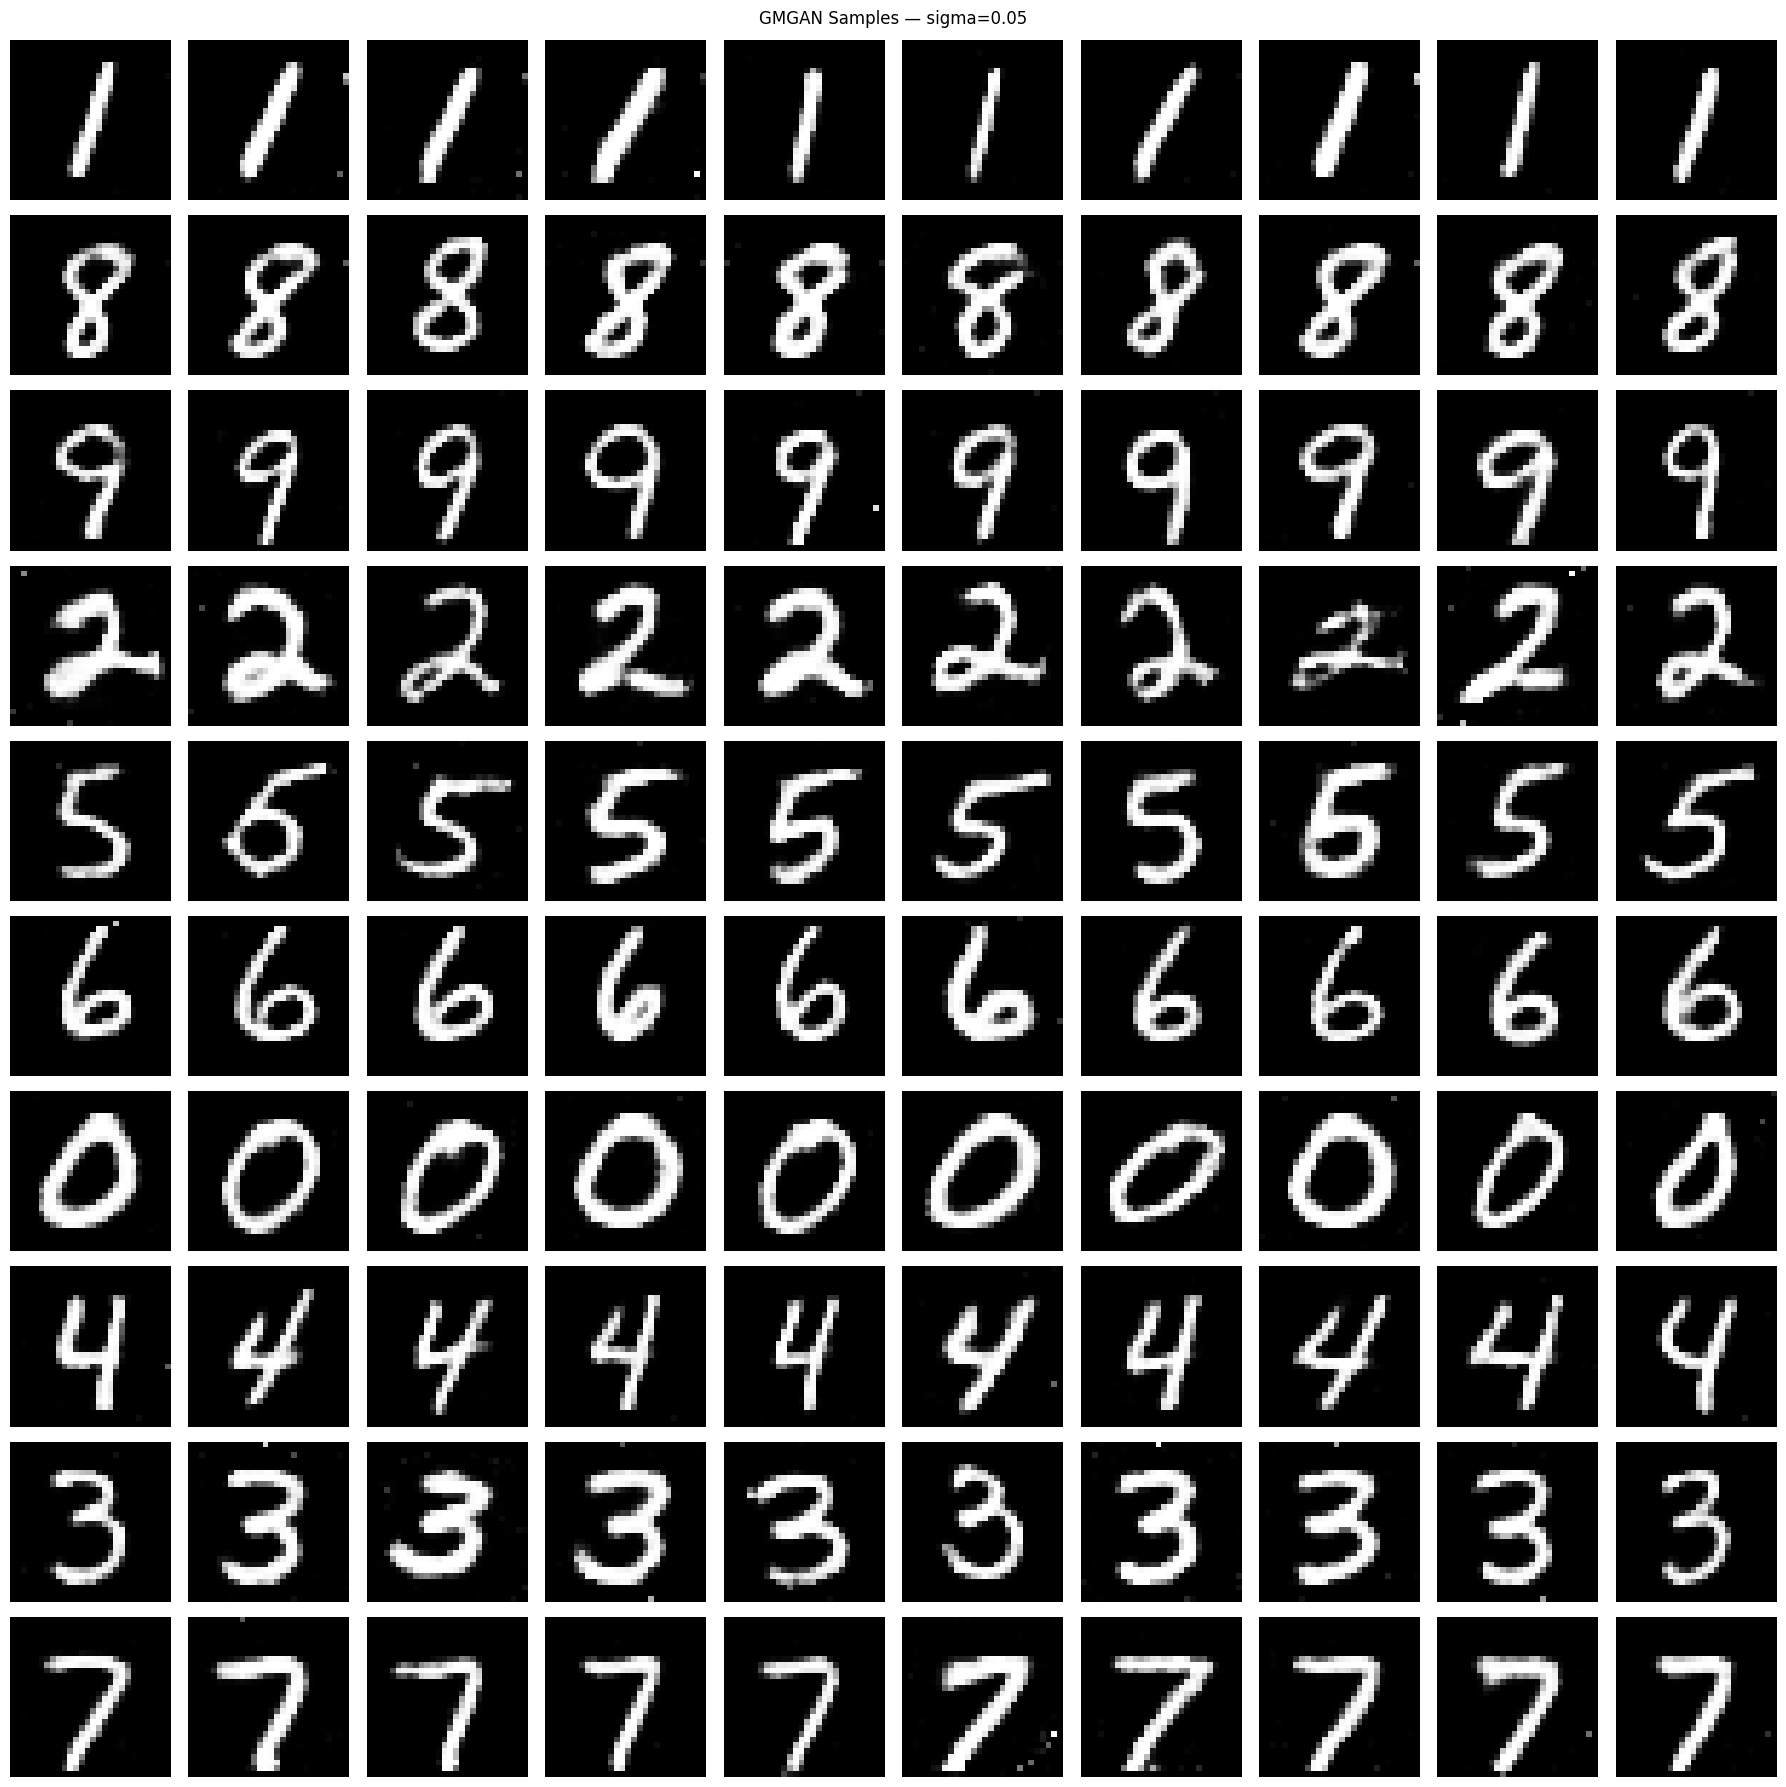


=== Sigma = 0.1 ===


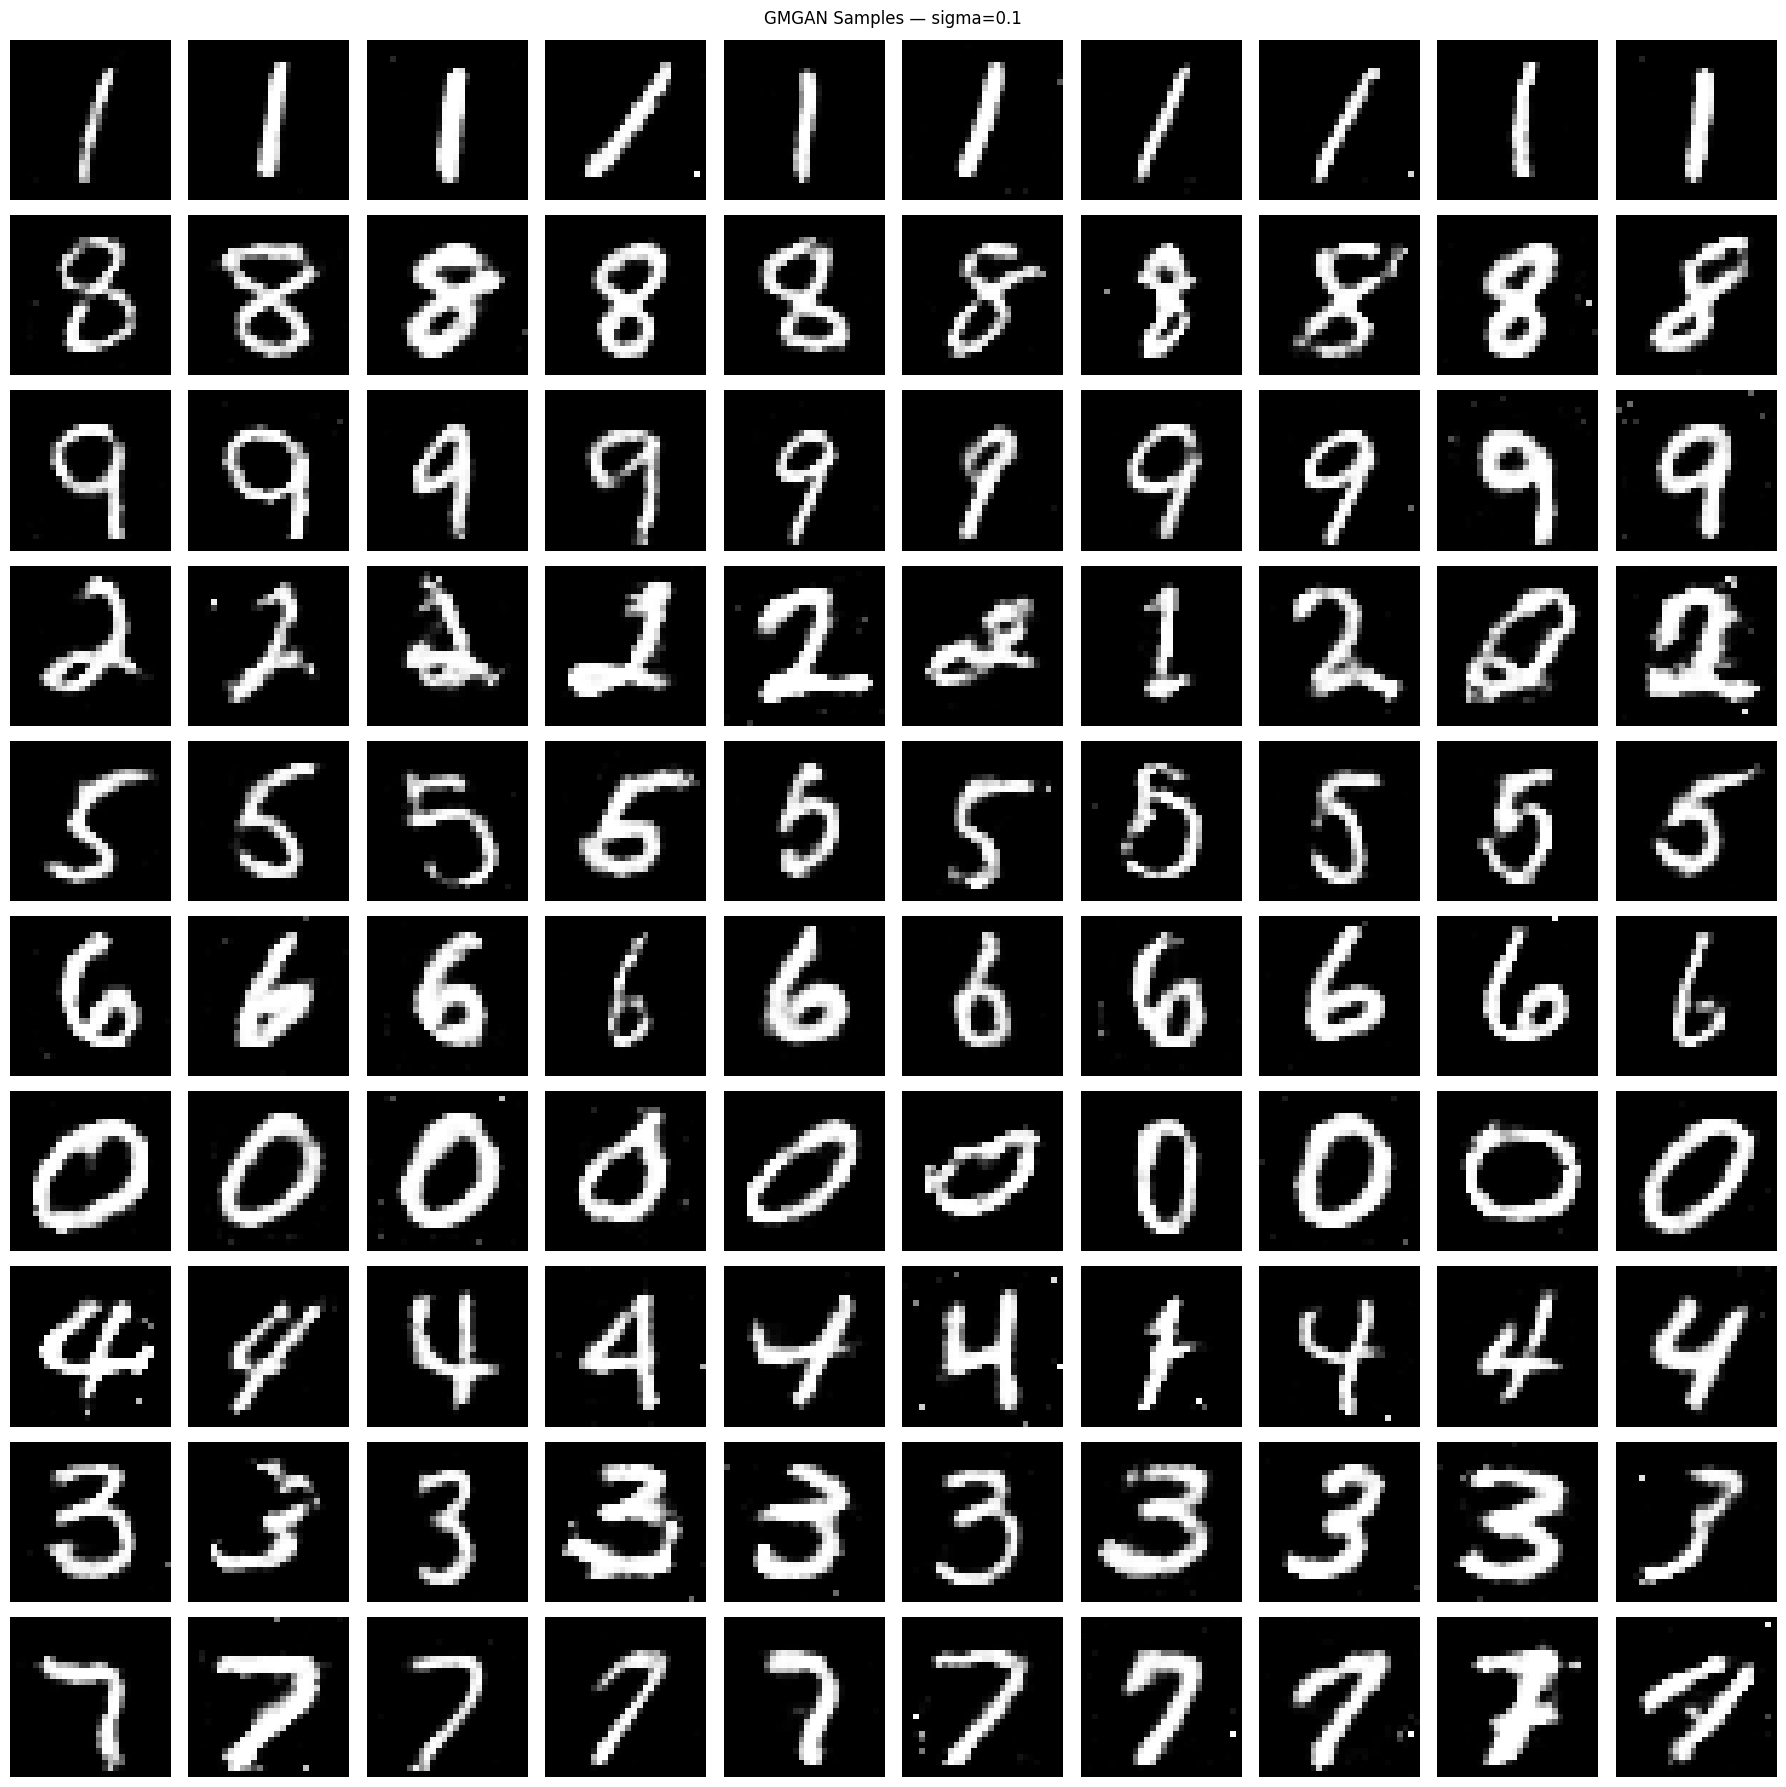


=== Sigma = 0.2 ===


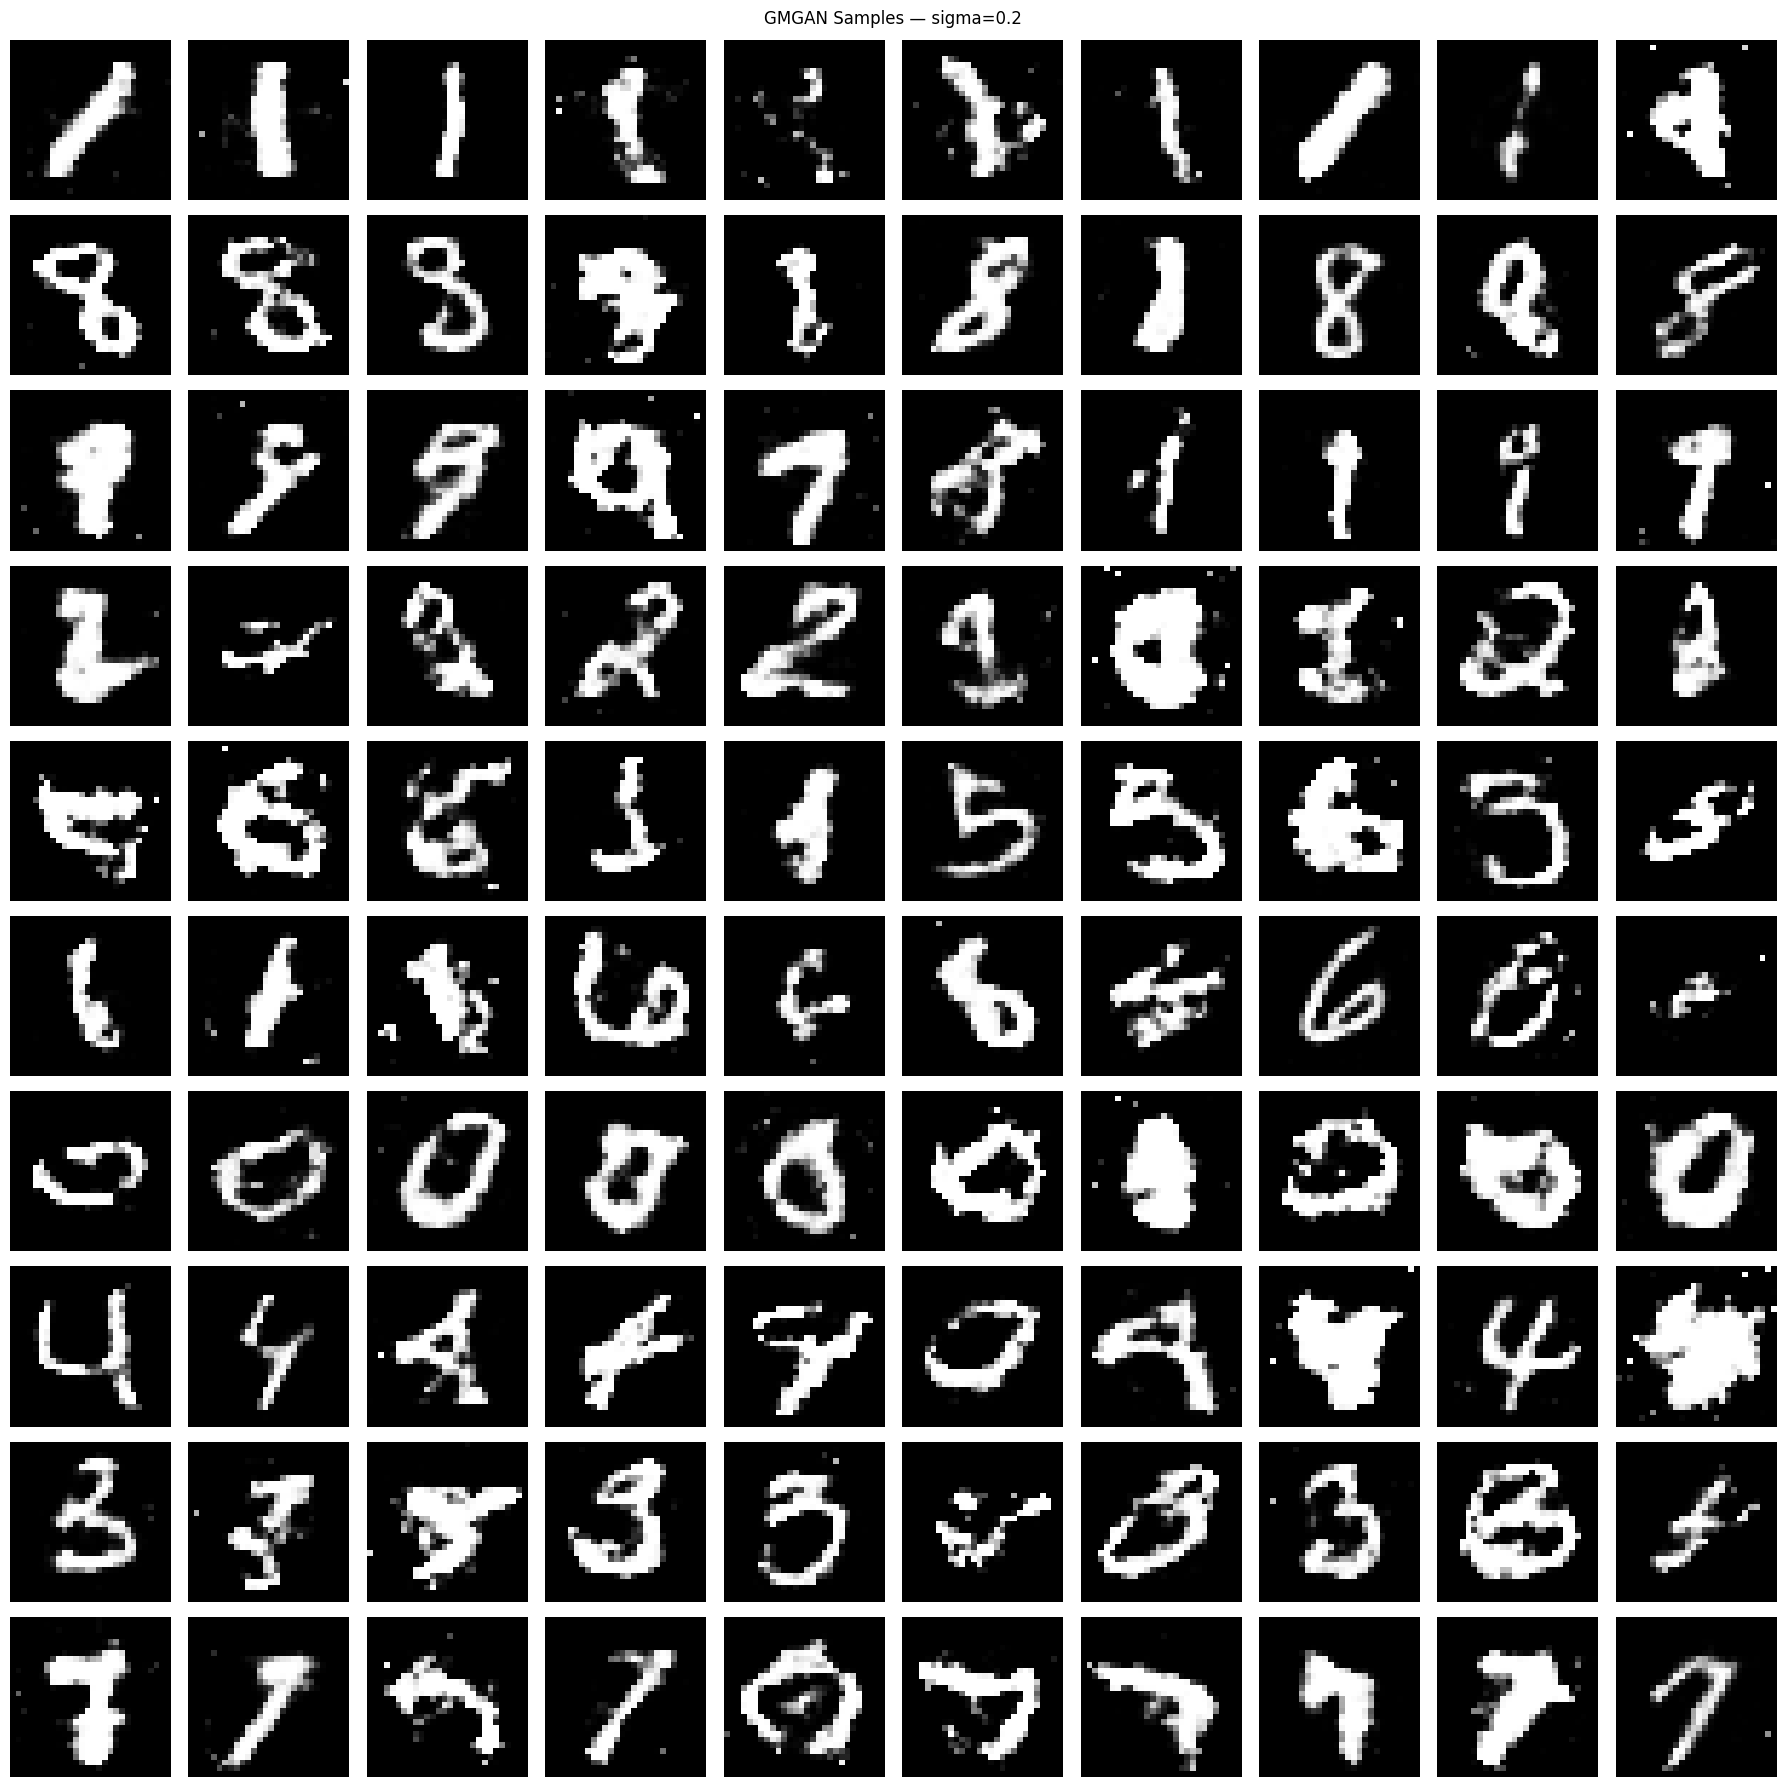

In [28]:
sigmas_to_test = [0.01, 0.05, 0.1, 0.2]

for sigma_eval in sigmas_to_test:
    print(f"\n=== Sigma = {sigma_eval} ===")

    model = GeneratorGMGAN(
        g_output_dim=mnist_dim, 
        latent_space_dim=latent_dim, 
        batch_generator=batch_generator, 
        K=K, 
        c=c, 
        sigma=sigma_eval
        ).to(device)

    model.load_state_dict(torch.load(checkpoint_path, map_location=device))


    generate_grid_all_clusters(
        model,
        K=10,
        n_samples=10,
        device=device,
        title=f"GMGAN Samples — sigma={sigma_eval}",
    )
